# A Model to predict user conversion

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# The train_users table

In [2]:
# import the train_users table

train_users = pd.read_csv('csvdata/train_users_2.csv')
train_users.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [3]:
# clean up the timestamps in the train_users dataframe 

train_users.timestamp_first_active = pd.to_datetime(train_users.timestamp_first_active.astype(str))
train_users.date_first_booking = pd.to_datetime(train_users.date_first_booking)
train_users.date_account_created = pd.to_datetime(train_users.date_account_created)

train_users.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,2009-03-19 04:32:55,NaT,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,2009-05-23 17:48:09,NaT,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,2009-06-09 23:12:47,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,2009-10-31 06:01:29,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,2009-12-08 06:11:05,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [4]:
# only keep the users for whom date_account_created matches timestamp_first_active 
# this is true for all the users in the test_users table, and for almost all the users in the train_users table 

train_users = train_users[train_users.timestamp_first_active.dt.date == train_users.date_account_created.dt.date]

In [5]:
# calculate the age buckets and add them to the train_users table 

def calc_age_bucket(age):
    '''
    this function calculates five year age buckets, given the age
    '''
    if age < 100.0:
        return (age // 5.0) + 1
    elif age >= 100.0:
        return 21.0
    elif np.isnan(age):
        return 0.0

train_users['age_bucket'] = train_users.age.apply(calc_age_bucket).astype('category')

In [6]:
# create features: year, month, day and dayofweek from date_account_created. 

train_users.loc[:,'year'] = train_users.date_account_created.dt.year.astype('category')
train_users.loc[:,'month'] = train_users.date_account_created.dt.month.astype('category')
#train_users.loc[:,'day'] = train_users.date_account_created.dt.day.astype('category')
train_users.loc[:,'dayofweek'] = train_users.date_account_created.dt.dayofweek.astype('category')

# mark a the following columns as categorical data
mylist = ['gender', 'signup_method', 'language', 'affiliate_channel', 
          'affiliate_provider', 'first_affiliate_tracked', 'signup_flow', 
          'signup_app', 'first_device_type', 'first_browser','age_bucket']
for x in mylist:
    train_users.loc[:,x] = train_users[x].astype('category')

#add seasons
mydict = {2:'spring', 3:'spring', 4:'spring', 
          5:'summer', 6:'summer', 7:'summer', 
          8:'fall', 9:'fall', 10:'fall',
          11:'winter', 12:'winter', 1:'winter'}
train_users.loc[:,'season'] = train_users.date_account_created.dt.month.apply(lambda x: mydict[x]).astype('category')

# only keep the users from 2014 for now - 
train_users = train_users[(train_users.year == 2014)]

In [7]:
# use 'id' as the index and drop the columns that are not needed anymore

ids = train_users.id
train_users = train_users.set_index('id')
train_users = train_users.drop(['date_account_created', 'timestamp_first_active', 'age', 'country_destination'], axis=1)

In [8]:
# separate the date_first_booking column as a column of 1/0 
# these are the labels that indicate the conversion of the user 

y_users = train_users.date_first_booking.notnull().astype(int)

# drop all the date_first_booking values - they're not present in the test_users table. 

train_users = train_users.drop('date_first_booking', axis=1)

# The sessions table

In [9]:
# import the sessions table

sessions = pd.read_csv('csvdata/sessions.csv')
sessions.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


In [10]:
# add a large numbe of features coming from the sessions table 
# this includes stuff such as number of clicks and the counts of many other things 
# all of this is numerical data

for y in ['action', 'action_type', 'action_detail']:
    df = sessions.groupby(['user_id', y]).size().unstack()
    for x in df.columns:
        s = df[x]
        train_users[y + '_' + x] = train_users.join(s)[x].fillna(0)

# now train_users has a large number of features derived from the sessions table 
train_users.values.shape

(76429, 539)

In [11]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA

# The Logistic Regression model

In [12]:
# convert the categorical variables into dummy variables

X_users = pd.get_dummies(train_users)

# scale to zero mean and unit variance
#X_users = pd.DataFrame(scale(X_users.values), index=X_users.index, columns=X_users.columns)

X_users.head()

,action_10,action_11,action_12,action_15,action_about_us,action_accept_decline,action_account,action_acculynk_bin_check_failed,action_acculynk_bin_check_success,action_acculynk_load_pin_pad,...,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,season_fall,season_spring,season_summer,season_winter
id,,,,,,,,,,,,,,,,,,,,,
d1mm9tcy42,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,1
yo8nz8bqcq,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,1
4grx6yxeby,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,1
ncf87guaf0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,1
4rvqpxoh3h,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,1


In [13]:
# pca = PCA(n_components=400)
# pca.fit(X_users)
# X_users = pd.DataFrame(pca.transform(X_users), X_users.index)

#pca.explained_variance_ratio_[:400].sum()

In [14]:
X_users.values.shape

(76429, 720)

Fold 1 out of 5:
training misclassification (percentage) : 22.1497146035
training log loss : 0.475684991567
validation misclassification (percentage) : 22.4453748528
validation log loss : 0.483537330509
roc auc score : 0.837949308131
------------------------------


/Users/partha/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


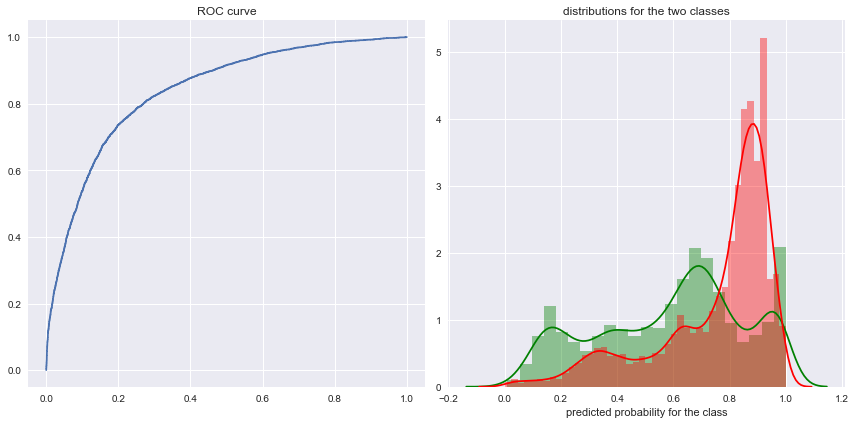

******************************************************************************************
Fold 2 out of 5:
training misclassification (percentage) : 22.3672374597
training log loss : 0.479513893133
validation misclassification (percentage) : 22.0136072223
validation log loss : 0.478165779706
roc auc score : 0.842519548986
------------------------------


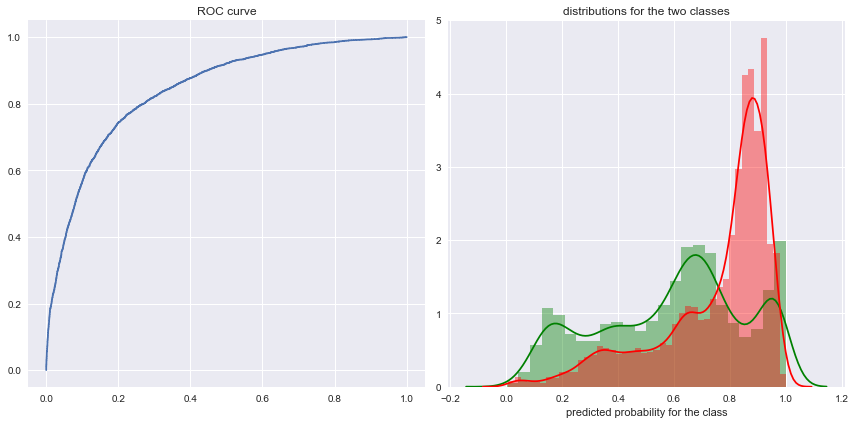

******************************************************************************************
Fold 3 out of 5:
training misclassification (percentage) : 22.0139672571
training log loss : 0.474648510061
validation misclassification (percentage) : 22.4519167866
validation log loss : 0.487198875523
roc auc score : 0.835411633562
------------------------------


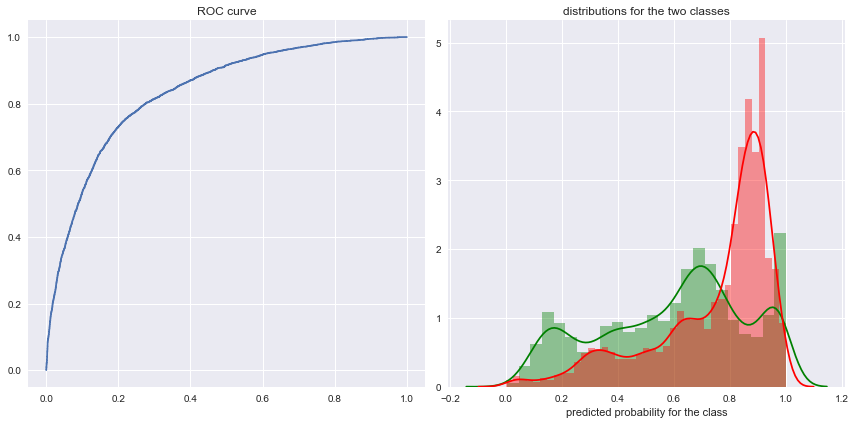

******************************************************************************************
Fold 4 out of 5:
training misclassification (percentage) : 22.3247141946
training log loss : 0.477609482077
validation misclassification (percentage) : 21.9678136857
validation log loss : 0.480670159043
roc auc score : 0.839253939735
------------------------------


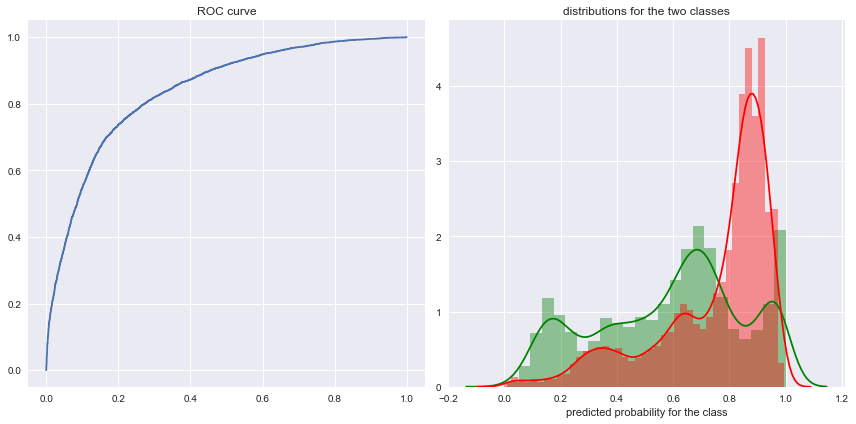

******************************************************************************************
Fold 5 out of 5:
training misclassification (percentage) : 21.9465524009
training log loss : 0.47662128855
validation misclassification (percentage) : 23.4020281322
validation log loss : 0.490044141466
roc auc score : 0.830867270329
------------------------------


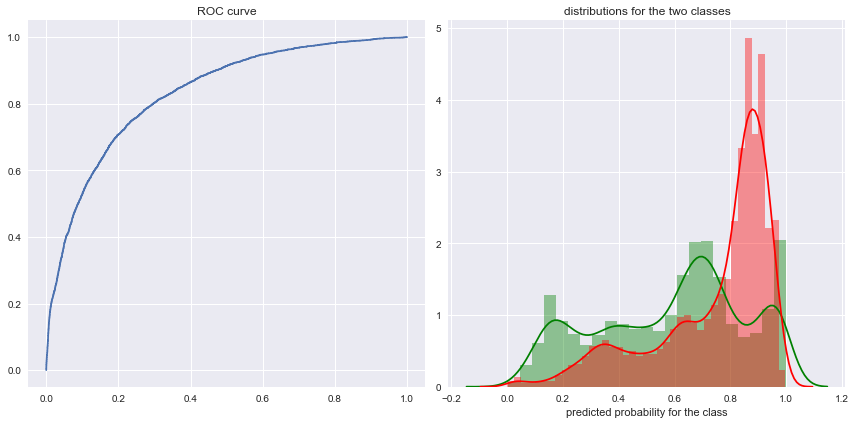

******************************************************************************************


In [15]:
kf = KFold(n_splits=5, shuffle=True)
fold = 0
for train, cv in kf.split(X_users):
    fold = fold + 1
    print 'Fold', fold, 'out of 5:'
    X_train, X_cv = X_users.iloc[train], X_users.iloc[cv]
    y_train, y_cv = y_users.iloc[train], y_users.iloc[cv]
    
#     # this code resample X_train and y_train:
#     samples = np.random.choice(len(X_train), 10000)
#     X_train = X_train.iloc[samples]
#     y_train = y_train.iloc[samples]
    
    # train a logistic regression classifier 
    clf = LogisticRegression(penalty='l2')
    #clf = MLPClassifier((8), activation='logistic')
    clf.fit(X_train, y_train)
    
    # check the performance on the training set
    predictions_train = clf.predict(X_train)
    E_train = (100. - (y_train == predictions_train).sum() * 100. / float(len(y_train)))
    print 'training misclassification (percentage) :', E_train
    prob_train = clf.predict_proba(X_train)
    print 'training log loss :', log_loss(y_train, prob_train)
    
    # check the performance on the validation set
    predictions_cv = clf.predict(X_cv)
    E_cv = (100. - (y_cv == predictions_cv).sum() * 100. / float(len(y_cv)))
    print 'validation misclassification (percentage) :', E_cv
    prob_cv = clf.predict_proba(X_cv)
    print 'validation log loss :', log_loss(y_cv, prob_cv)
    
    # print the area under the ROC curve 
    print 'roc auc score :', roc_auc_score(y_cv, prob_cv[:, 1])
    print '-'*30
    
    # plot the roc curve and probability distributions of the two classes 
    fpr, tpr, thresholds = roc_curve(y_cv, prob_cv[:, 1])
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))
    ax1.plot(fpr, tpr)
    ax1.set_title('ROC curve')
    
    # plot the probability distribution for the two classes on the validation set
    distr_p1 = pd.Series(prob_cv[:, 1], index=y_cv).loc[1].values
    distr_p0 = pd.Series(prob_cv[:, 0], index=y_cv).loc[0].values
    ax2.legend()
    ax2 = sns.distplot(distr_p1, color='green', label='booked')
    ax2 = sns.distplot(distr_p0, color='red', label='did not book')
    ax2.set_title('distributions for the two classes')
    ax2.set_xlabel('predicted probability for the class')
    fig.tight_layout()
    plt.show()
    print '*'*90


In [16]:
# vary the threshold

for mythreshold in np.linspace(0.40, 0.60, 11):
    print 'threshold:', mythreshold, 'misclassification percentage:', 100. * ((prob_cv[:, 0] > mythreshold) == y_cv).sum()/float(len(y_cv))

threshold: 0.4 misclassification percentage: 23.7095191364
threshold: 0.42 misclassification percentage: 23.6048413477
threshold: 0.44 misclassification percentage: 23.500163559
threshold: 0.46 misclassification percentage: 23.5459600916
threshold: 0.48 misclassification percentage: 23.4151128557
threshold: 0.5 misclassification percentage: 23.4020281322
threshold: 0.52 misclassification percentage: 23.343146876
threshold: 0.54 misclassification percentage: 23.2777232581
threshold: 0.56 misclassification percentage: 23.3235197906
threshold: 0.58 misclassification percentage: 23.4805364737
threshold: 0.6 misclassification percentage: 23.8861629048


# Random Forests

Fold 1 out of 5:
training misclassification (percentage) : 0.224064897045
training log loss : 0.133545857255
validation misclassification (percentage) : 22.4977103232
validation log loss : 0.508513248561
roc auc score  : 0.835743579511
oob score: 0.768329980537
------------------------------


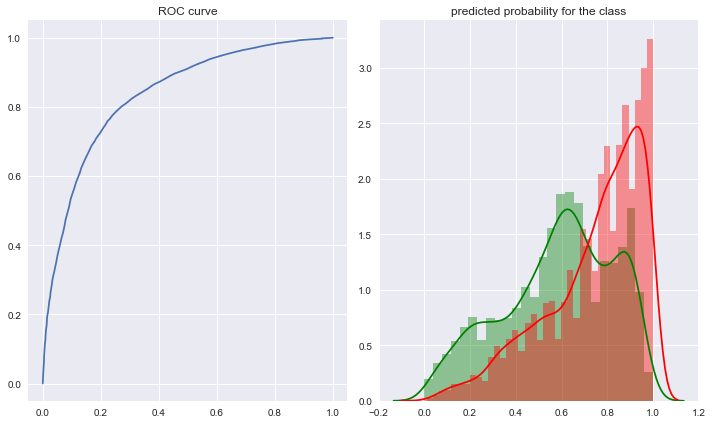

******************************************************************************************
Fold 2 out of 5:
training misclassification (percentage) : 0.230606937834
training log loss : 0.1337990873
validation misclassification (percentage) : 22.6808844694
validation log loss : 0.507046168065
roc auc score  : 0.830798525567
oob score: 0.766432788708
------------------------------


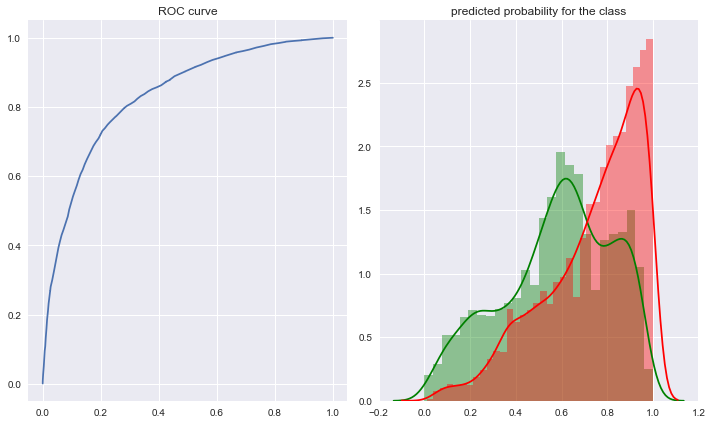

******************************************************************************************
Fold 3 out of 5:
training misclassification (percentage) : 0.206074284873
training log loss : 0.13381283207
validation misclassification (percentage) : 22.3799555149
validation log loss : 0.499537656051
roc auc score  : 0.836436301462
oob score: 0.768493531557
------------------------------


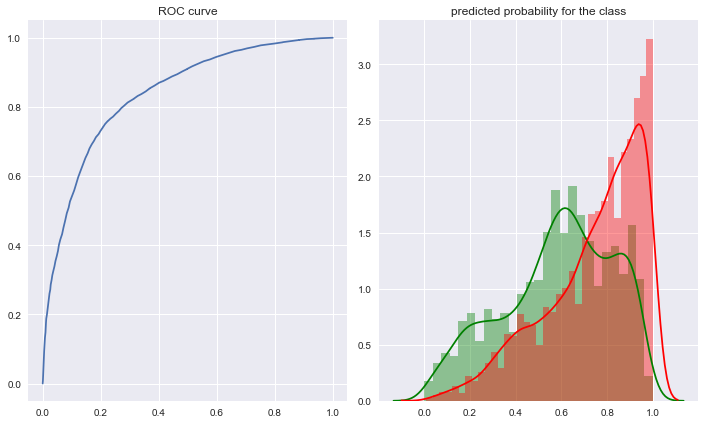

******************************************************************************************
Fold 4 out of 5:
training misclassification (percentage) : 0.22079387665
training log loss : 0.134031201858
validation misclassification (percentage) : 22.9033102185
validation log loss : 0.506544605166
roc auc score  : 0.83164026555
oob score: 0.767381384623
------------------------------


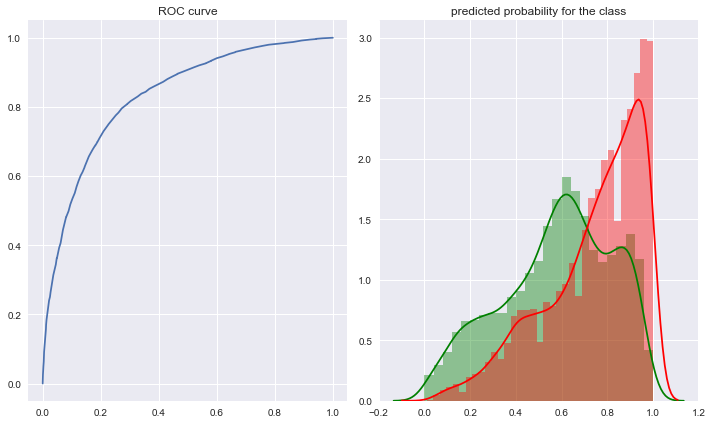

******************************************************************************************
Fold 5 out of 5:
training misclassification (percentage) : 0.220790265603
training log loss : 0.13411003002
validation misclassification (percentage) : 22.7019954203
validation log loss : 0.506105926526
roc auc score  : 0.833504078294
oob score: 0.767859479262
------------------------------


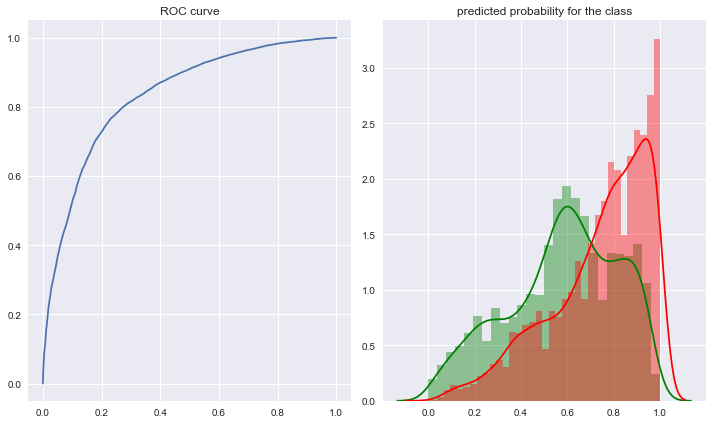

******************************************************************************************


In [17]:
kf = KFold(n_splits=5, shuffle=True)
fold = 0
for train, cv in kf.split(X_users):
    fold = fold + 1
    print 'Fold', fold, 'out of 5:'
    X_train, X_cv = X_users.iloc[train], X_users.iloc[cv]
    y_train, y_cv = y_users.iloc[train], y_users.iloc[cv]
    
#     # this code resample X_train and y_train:
#     samples = np.random.choice(len(X_train), 100000)
#     X_train = X_train.iloc[samples]
#     y_train = y_train.iloc[samples]
    
    # train a logistic regression classifier 
    clf = RandomForestClassifier(n_estimators=100, oob_score=True)
    clf.fit(X_train, y_train)
    
    # check the performance on the training set
    predictions_train = clf.predict(X_train)
    print 'training misclassification (percentage) :', (100. - (y_train == predictions_train).sum() * 100. / float(len(y_train)))
    prob_train = clf.predict_proba(X_train)
    print 'training log loss :', log_loss(y_train, prob_train)
    
    # check the performance on the validation set
    predictions_cv = clf.predict(X_cv)
    print 'validation misclassification (percentage) :', (100. - (y_cv == predictions_cv).sum() * 100. / float(len(y_cv)))
    prob_cv = clf.predict_proba(X_cv)
    print 'validation log loss :', log_loss(y_cv, prob_cv)
    
    # print the area under the ROC curve 
    print 'roc auc score  :', roc_auc_score(y_cv, prob_cv[:, 1])
    print 'oob score:', clf.oob_score_
    print '-'*30
    
    # plot the roc curve
    fpr, tpr, thresholds = roc_curve(y_cv, prob_cv[:, 1])
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,6))
    ax1.plot(fpr, tpr)
    ax1.set_title('ROC curve')
    # plot the probability distribution for the two classes
    distr_p1 = pd.Series(prob_cv[:,1], index=y_cv).loc[1].values
    distr_p0 = pd.Series(prob_cv[:,0], index=y_cv).loc[0].values
    ax2.legend()
    ax2 = sns.distplot(distr_p1, color='green', label='booked')
    ax2 = sns.distplot(distr_p0, color='red', label='did not book')
    ax2.set_title('predicted probability for the class')
    fig.tight_layout()
    plt.show()
    print '*'*90

In [18]:
# vary the threshold

for mythreshold in np.linspace(0.40, 0.60, 11):
    print 'threshold:', mythreshold, 'misclassification percentage:', 100. * ((prob_cv[:, 0] > mythreshold) == y_cv).sum()/float(len(y_cv))

threshold: 0.4 misclassification percentage: 24.6581615963
threshold: 0.42 misclassification percentage: 24.0300948642
threshold: 0.44 misclassification percentage: 23.375858685
threshold: 0.46 misclassification percentage: 22.9048086359
threshold: 0.48 misclassification percentage: 22.7150801439
threshold: 0.5 misclassification percentage: 22.6038599935
threshold: 0.52 misclassification percentage: 22.459928034
threshold: 0.54 misclassification percentage: 22.682368335
threshold: 0.56 misclassification percentage: 22.8590121034
threshold: 0.58 misclassification percentage: 23.1076218515
threshold: 0.6 misclassification percentage: 23.5590448152


In [19]:
# only keep the features that are important enough and model again

s = pd.Series(clf.feature_importances_).sort_values(ascending=False)

X_u = X_users[X_users.columns[s.iloc[:150].index]]

Fold 1 out of 5:
training error (percentage) : 0.240419999019
training log loss : 0.132706856716
validation error (percentage) : 22.6089231977
validation log loss : 0.501659906545
roc auc score : 0.837195810511
------------------------------


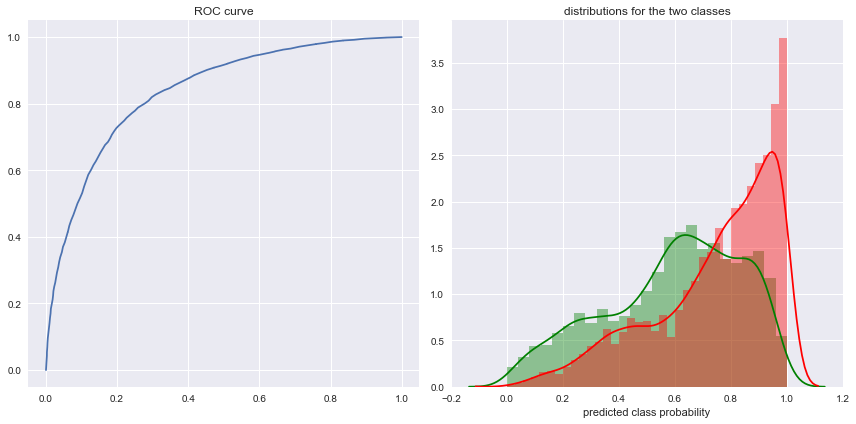

******************************************************************************************
Fold 2 out of 5:
training error (percentage) : 0.224064897045
training log loss : 0.132060754447
validation error (percentage) : 22.7397618736
validation log loss : 0.506742442029
roc auc score : 0.830459361064
------------------------------


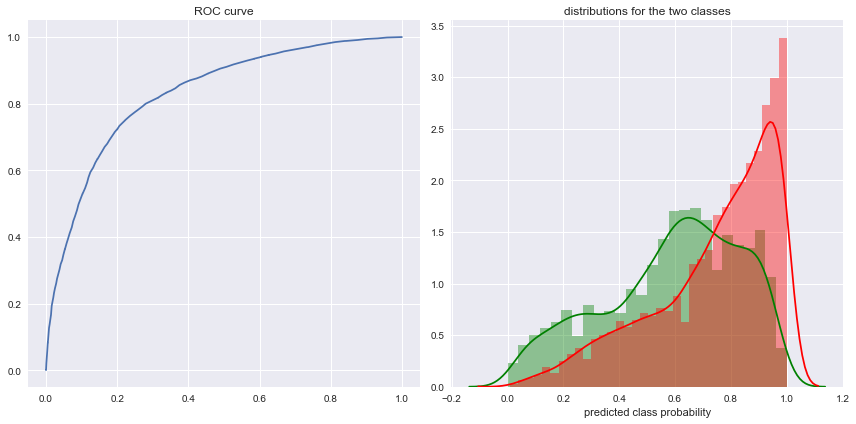

******************************************************************************************
Fold 3 out of 5:
training error (percentage) : 0.22079387665
training log loss : 0.13144286278
validation error (percentage) : 22.8640586157
validation log loss : 0.528233852693
roc auc score : 0.828573897672
------------------------------


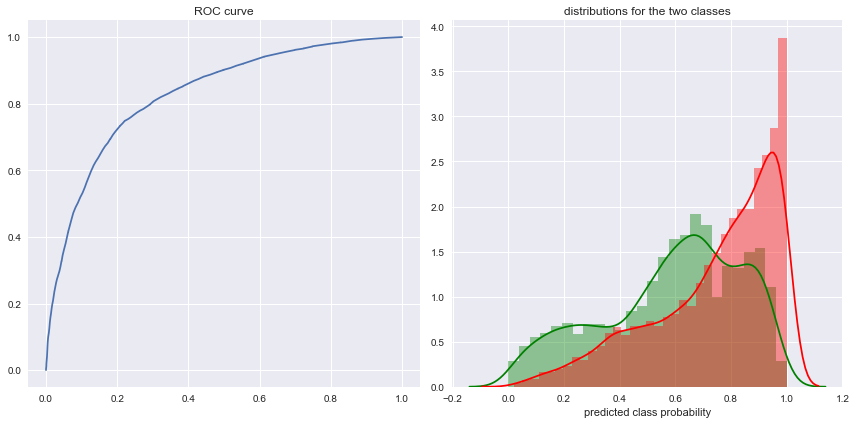

******************************************************************************************
Fold 4 out of 5:
training error (percentage) : 0.228971427637
training log loss : 0.132742752859
validation error (percentage) : 22.2752845741
validation log loss : 0.500451423289
roc auc score : 0.838800305785
------------------------------


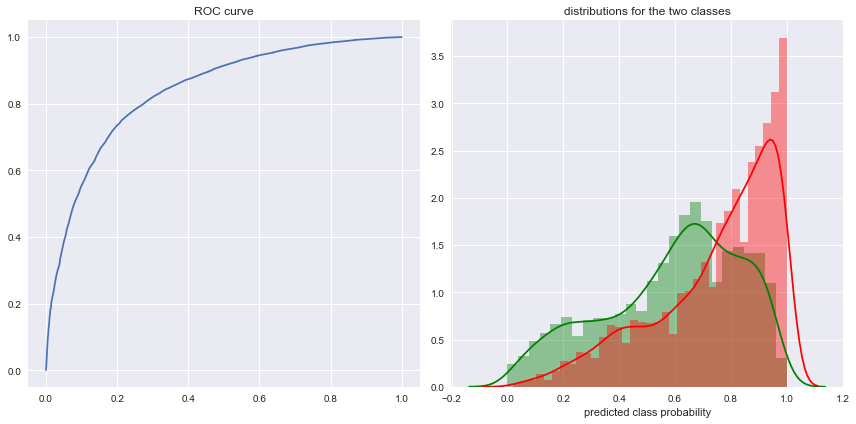

******************************************************************************************
Fold 5 out of 5:
training error (percentage) : 0.225696715949
training log loss : 0.132252999719
validation error (percentage) : 22.5646058227
validation log loss : 0.510573181836
roc auc score : 0.833924590174
------------------------------


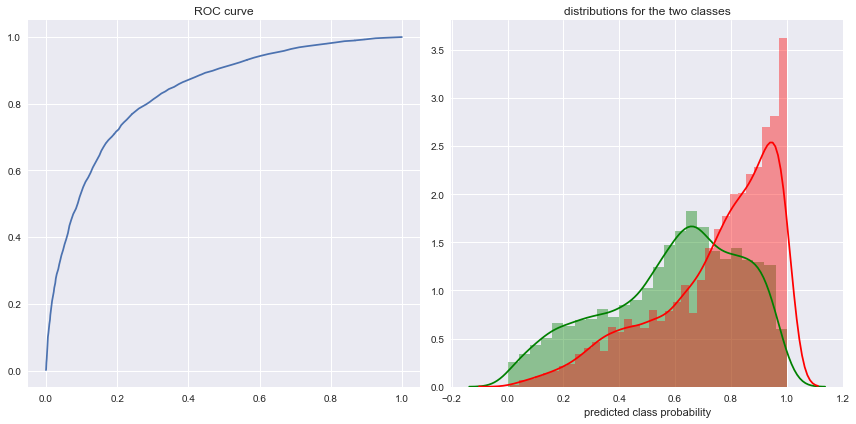

******************************************************************************************


In [20]:
kf = KFold(n_splits=5, shuffle=True)
fold=0
for train, cv in kf.split(X_u):    
    fold = fold + 1
    print 'Fold', fold, 'out of 5:'
    X_train, X_cv = X_u.iloc[train], X_u.iloc[cv]
    y_train, y_cv = y_users.iloc[train], y_users.iloc[cv]
    newclf = RandomForestClassifier(n_estimators=100, oob_score=True)
    #newclf = LogisticRegression()
    newclf.fit(X_train, y_train)
    
    predictions_train = newclf.predict(X_train)
    print 'training error (percentage) :', (100. - (y_train == predictions_train).sum() * 100. / float(len(y_train)))
    prob_train = newclf.predict_proba(X_train)
    print 'training log loss :', log_loss(y_train, prob_train)
    
    predictions_test = newclf.predict(X_cv)
    print 'validation error (percentage) :', (100. - (y_cv == predictions_test).sum() * 100. / float(len(y_cv)))
    prob_cv = newclf.predict_proba(X_cv)
    print 'validation log loss :', log_loss(y_cv, prob_cv)
    
    print 'roc auc score :', roc_auc_score(y_cv, prob_cv[:, 1])
    print 'oob score:', clf.oob_score_
    print '-'*30
    
    fpr, tpr, thresholds = roc_curve(y_cv, prob_cv[:, 1])
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))
    ax1.plot(fpr, tpr)
    ax1.set_title('ROC curve')
    
    # plot the probability distribution for the two classes
    distr_p1 = pd.Series(prob_cv[:,1], index=y_cv).loc[1].values
    distr_p0 = pd.Series(prob_cv[:,0], index=y_cv).loc[0].values
    ax2.legend()
    ax2 = sns.distplot(distr_p1, color='green', label='booked')
    ax2 = sns.distplot(distr_p0, color='red', label='did not book')
    ax2.set_title('distributions for the two classes')
    ax2.set_xlabel('predicted class probability')
    fig.tight_layout()
    plt.show()
    print '*'*90


# Ignore what follows

In [21]:
stop_here =

SyntaxError: invalid syntax (<ipython-input-21-ce4420942638>, line 1)

In [ ]:
featurelist = X_u.columns
for i,x in enumerate(featurelist):
    for y in featurelist[i:]:
        X_u.loc[:, x + '*' + y] = X_u.loc[:, x] * X_u.loc[:, y]
print 'Yay! added more features!'

In [ ]:
fpr, tpr, thresholds = roc_curve(y_cv, prob_cv[:, 1])
fig, ax = plt.subplots()
#plt.plot(thresholds, fpr, color='blue')
#plt.plot(thresholds, tpr, color='green')
plt.plot(fpr, tpr)

In [ ]:
X_u.columns

In [ ]:
sessions.groupby(['user_id', 'action']).size().unstack()

In [ ]:
view = sessions.groupby(['user_id', 'action_type']).size().unstack().view
train_users['view'] = train_users.join(view).view.fillna(0)

In [ ]:
# add booking_request data

booking_request = sessions.groupby(['user_id', 'action_type']).size().unstack().booking_request
train_users['booking_request'] = train_users.join(booking_request).booking_request.fillna(0)

In [ ]:
# add the clicks data

click_series = sessions.groupby(['user_id', 'action_type']).size().unstack().click.sort_index()
train_users['click'] = train_users.join(click_series).click.fillna(0)

In [ ]:
train_users.set_index('id').loc[np.setdiff1d(train_users.id.unique(), sessions.user_id.unique())].groupby(['country_destination', 'year']).size().unstack()[2014].sum()

In [ ]:
# all the users in the sessions table are from 2014

train_users.set_index('id').loc[np.intersect1d(train_users.id.unique(), sessions.user_id.unique())].groupby(['year']).size()

In [ ]:
len(booked_ya), len(booked_na)

In [ ]:
len(np.intersect1d(ids.unique(), sessions.user_id.unique()))

In [ ]:
len(booked_ya), len(booked_na)

In [ ]:
train_users.isnull().sum().sort_values()

In [ ]:
ids = train_users.index

numeric = pd.DataFrame(pd.Series(data=0, index = ids))

# add features coming from the sessions table 

for y in ['action', 'action_type', 'action_detail']:
    df = sessions.groupby(['user_id', y]).size().unstack()

    for x in df.columns:
        s = df[x]
        numeric[y + '_' + x] = numeric.join(s)[x].fillna(0)

from sklearn.decomposition import PCA
pca = PCA()
pca.fit(numeric)
numeric = pca.transform(numeric)

len(pca.explained_variance_ratio_[pca.explained_variance_ratio_ > 0.001])

numeric = pd.DataFrame(numeric[:,:22], index=ids)

In [ ]:
train_users = train_users.join(numeric)

In [ ]:
s = sessions.groupby(['user_id', 'action_type']).size().unstack().booking_response.fillna(0)

In [ ]:
s.head(20)

In [ ]:
y_users.loc[s.sort_index().index].head(20)

In [ ]:
s[:150].sum()